In [9]:
import os
import requests
import zipfile
import tarfile
import hashlib
from d2l import torch as d2l
import torch
from torch import nn
import pandas as pd
import numpy as np
train_data = pd.read_csv('E:\python_Project\jupyterNotebook\加州房价预测\\train.csv')
test_data = pd.read_csv('E:\python_Project\jupyterNotebook\加州房价预测\\test.csv')

print(train_data.shape)
print(test_data.shape)
# 去掉冗余数据
redundant_cols=['Address','Summary','City','State']
for c in redundant_cols:
    del test_data[c],train_data[c]
# print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))    # ilod[:,1:-1]去除最后1列和第1列
# 处理缺失值，变成均值
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index # object是str类或数字混合类型（mixed），将特征为数字的列单独拿出。并保存列名到numeric
all_features[numeric_features]=all_features[numeric_features].apply(lambda x:(x-x.mean())/(x.std()))
all_features[numeric_features]=all_features[numeric_features].fillna(0)
print(numeric_features)
for in_object in all_features.dtypes[all_features.dtypes=='object'].index:
    print(in_object.ljust(20),len(all_features[in_object].unique()))
features=list(numeric_features)
features.extend(['Type','Bedrooms'])
all_features=all_features[features]

# dummpy_na=True将缺失值也当做合法的特征值并为其创建指示特征
# get_dummies即上述将离散值转换为指示特征
all_features=pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(47439, 41)
(31626, 40)
Index(['Sold Price', 'Year built', 'Lot', 'Bathrooms', 'Full bathrooms',
       'Total interior livable area', 'Total spaces', 'Garage spaces',
       'Elementary School Score', 'Elementary School Distance',
       'Middle School Score', 'Middle School Distance', 'High School Score',
       'High School Distance', 'Tax assessed value', 'Annual tax amount',
       'Listed Price', 'Last Sold Price', 'Zip'],
      dtype='object')
Type                 174
Heating              2660
Cooling              911
Parking              9913
Bedrooms             278
Region               1259
Elementary School    3568
Middle School        809
High School          922
Flooring             1740
Heating features     1763
Cooling features     596
Appliances included  11290
Laundry features     3031
Parking features     9695
Listed On            2815
Last Sold On         6949


(79065, 472)

In [14]:
n_train=train_data.shape[0]
train_features = d2l.tensor(all_features[:n_train].values, dtype=d2l.float32)
test_features = d2l.tensor(all_features[n_train:].values, dtype=d2l.float32)
train_labels = d2l.tensor(
    train_data['Sold Price'].values.reshape(-1, 1), dtype=d2l.float32)
print('train label shape',train_labels.shape)

train label shape torch.Size([47439, 1])


In [34]:
# 训练
loss = nn.MSELoss()


# def get_net():
#     net = nn.Sequential(nn.Linear(in_features,1))
#     return net
class MLP(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.layer1 = nn.Linear(in_features,256)
        self.layer2 = nn.Linear(256,64)
        self.out = nn.Linear(64,1)
        
    def forward(self, X):
        X = F.relu(self.layer1(X))
        X = F.relu(self.layer2(X))
        return self.out(X)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
in_features = train_features.shape[1]
net=MLP(in_features).to(device)
def log_rmse(net,features,labels):
    clipped_preds=torch.clamp(net(features),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [35]:
# K折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
# 返回K折后的平均值
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [ ]:
# 模型选择
k,num_epochs,lr,weight_decay,batch_size=5,400,0.1,0,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,
                      weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse5.964584, 验证log rmse5.920898
折2，训练log rmse5.805928, 验证log rmse5.544358


训练log rmse：5.668123


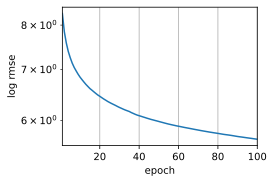

In [32]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。 
    with torch.no_grad():
        preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)